In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

import pennylane as qml
import pandas as pd

In [30]:
df = pd.read_csv('./dataset.csv')

In [31]:
n_train = 50

y_train = torch.tensor(df['nat_demand'].to_numpy()[:n_train]).to(torch.float)
x_train = torch.tensor(df[sorted("T2M_toc	QV2M_toc TQL_toc W2M_toc T2M_san QV2M_san TQL_san W2M_san T2M_dav QV2M_dav TQL_dav W2M_dav".split())].to_numpy()[:n_train]).to(torch.float)

xs = torch.tensor([(x_train[:,3 * i : 3 * i + 3].sum(dim=1)/3).tolist() for i in range(4)]).T
print(xs[1])
y_train = (y_train-y_train.min())/(y_train.max()-y_train.min())


tensor([1.7476e-02, 2.3959e+01, 3.5131e-02, 1.2807e+01])


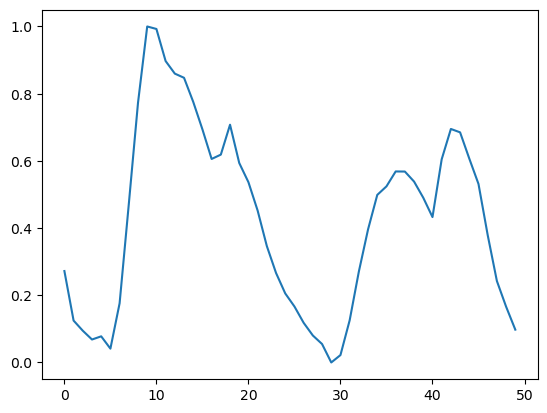

In [32]:
plt.plot(y_train)
plt.show()

In [33]:
temp = [i for i in range(12)]
temp_result = [sum(temp[3 * i : 3 * i + 3]) / 3 for i in range(4)]
print(temp_result)

[1.0, 4.0, 7.0, 10.0]


In [34]:
class G1(nn.Module):
    '''
    G for V(G)
    '''
    def __init__(self, input, hidden1, hidden2):
        super(G1, self).__init__()
        self.li1 = nn.Linear(input, hidden1)
        self.li2 = nn.Linear(hidden1, hidden2)
        self.li3 = nn.Linear(hidden2, 2*input-1)
        
    def forward(self, x):
        x = self.li1(x)
        x = F.relu(x)
        x = self.li2(x)
        x = F.relu(x)
        x = self.li3(x)
        x = 2*torch.pi*F.relu(x)
        return x

In [35]:
n_qu = 4
dev = qml.device("default.qubit", wires = n_qu)

def embedding(params, n_qu):
    '''
    embedding layer
    '''
    n = n_qu
    for i in range(n):
        qml.Hadamard(i)
        qml.RZ(2.0 * params[i], i)
    
    for i in range(n - 1):
        qml.IsingZZ(2.0 * params[n + i] ,[i , i + 1])

@qml.qnode(dev, interface="torch")
def fidelity(vec1, vec2, n_qu):
    '''
        Args:
            vec1 : list, (2n - 1)개의 element로 이루어진 vector
            vec2 : list, (2n - 1)개의 element로 이루어진 vector
    '''
    embedding(vec1, n_qu) # Phi(x1) circuit 적용
    qml.adjoint(embedding)(vec2, n_qu) # Phi^t(x2) 적용
    return qml.probs()


In [42]:
epochs = 10

model = G1(input = n_qu, hidden1=3*n_qu, hidden2=2*n_qu)

optimizer = torch.optim.Adam(params=model.parameters(), lr = 0.3, betas=[0.9,0.999])

for epoch in range(epochs):
    optimizer.zero_grad()
    risk = 0
    f_loss_list = []

    for i in range(n_train):
        for j in range(n_train):
            f_loss = fidelity(model(xs[i]),model(xs[j]),n_qu=n_qu)[0]
            f_loss_list.append(f_loss.detach().numpy())
            loss = f_loss - (y_train[i]-y_train[j])**2
            loss = -(loss**2)
            risk += loss

    print(np.mean(np.array(f_loss_list)))
    risk /= (n_train**2)
    risk.backward()
    optimizer.step()
    print(f'epoch : {epoch}, risk : {risk}') if epoch%1==0 else None

0.22831768
epoch : 0, risk : -0.17420436441898346
0.22762385
epoch : 1, risk : -0.1562039852142334


KeyboardInterrupt: 